In [26]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts, raster_plot

from utils import *
from process import *
from analysis import *
from plots import *

%matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [27]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

In [28]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [29]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalization_scale": "range",
        "fr_normalize_quantile": 0.2,
        "soft_normalize_cut": 26.666666666666668,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            0,
            1
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3,
            4
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "drifting_gratings_knee": true,
        "static_gratings_knee": false,
        "natural_s

## Load selected units in area of interest

In [30]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


In [31]:
if info['unit_has_ccf']:
    units_dv_coords = sel_units['dorsal_ventral_ccf_coordinate'].copy()
else:
    units_dv_coords = sel_units['dorsal_ventral_ccf_coordinate'].rename('dorsal_ventral_coordinate')

## Load LFP channels

In [32]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 1.3e-06 1.82e-06 ... -1.55e-05 -8.287e-06
Attributes:
    fs:       1249.99999145772

In [33]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
display(channel_group_map)

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850245925,7,8549.400000,1424.500000,8020.300000
850245931,7,8549.400000,1424.500000,8020.300000
850245937,7,8549.400000,1424.500000,8020.300000
850245943,7,8549.400000,1424.500000,8020.300000
850245949,6,8586.111111,1317.000000,8026.555556
...,...,...,...,...
850246077,0,8844.181818,583.363636,8054.818182
850246079,0,8844.181818,583.363636,8054.818182
850246081,0,8844.181818,583.363636,8054.818182


## Load PCA results

In [34]:
stimulus_name = 'drifting_gratings'
filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

with xr.open_dataset(filepath_prefix + '_pop_vec.nc') as f:
    pop_vec_cond = f.load()
pca_df = pd.read_csv(filepath_prefix + '_units_pca.csv', index_col='unit_id')

#orientation_group_df = pd.read_csv(filepath_prefix + '_pca_orient_groups.csv',
#                                   index_col='orienation_group_id', converters={'orientation': eval})

## get data

In [35]:
# Get map from unit to channel group id
channels = session.channels.loc[session.channels['structure_acronym'] == ecephys_structure_acronym]
unit_channel = pd.Series(channel_group_map.loc[sel_units['peak_channel_id'], 'group_id'].values,
                         index=sel_units_id, name='channel_group_id')

# Get stimulus trials
extend_time = 0.2
extend_time, = get_parameters({'filter_extend_time': extend_time}, parameters_dict, enter_parameters)

drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)
aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0. - extend_time, grating_duration + extend_time))
aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

# Get spike times
spike_times = session.presentationwise_spike_times(stimulus_presentation_ids=grating_ids, unit_ids=sel_units_id)

## Get beta wave

In [36]:
# Get filtered LFP
freq_band = [20., 40.]
freq_band, = get_parameters({'filter_freq_band': freq_band}, parameters_dict, enter_parameters)
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

lfp_beta = bandpass_lfp(aligned_lfp, freq_band)
spike_phase_beta = get_spike_phase(spike_times, lfp_beta, unit_channel)

Filter band: (20.0, 40.0) Hz


## Get gamma wave

In [37]:
# Get filtered LFP
freq_band = [40., 80.]
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

lfp_gamma = bandpass_lfp(aligned_lfp, freq_band)
spike_phase_gamma = get_spike_phase(spike_times, lfp_gamma, unit_channel)

Filter band: (40.0, 80.0) Hz


## PC and LFP

In [38]:
n_orient = pop_vec_cond.orientation.size
n_tfreq = pop_vec_cond.temporal_frequency.size
cmap1 = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
cmap2 = plt.cm.get_cmap('jet')(np.arange(n_tfreq) / n_tfreq)[:, :3]

/tmp/ipykernel_1858174/2135894354.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
/tmp/ipykernel_1858174/2135894354.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('jet')(np.arange(n_tfreq) / n_tfreq)[:, :3]


## Select gamma or beta

In [39]:
wave = 'gamma'
if wave == 'gamma':
    lfp = lfp_gamma
    spikes = spike_phase_gamma
else:
    lfp = lfp_beta
    spikes = spike_phase_beta

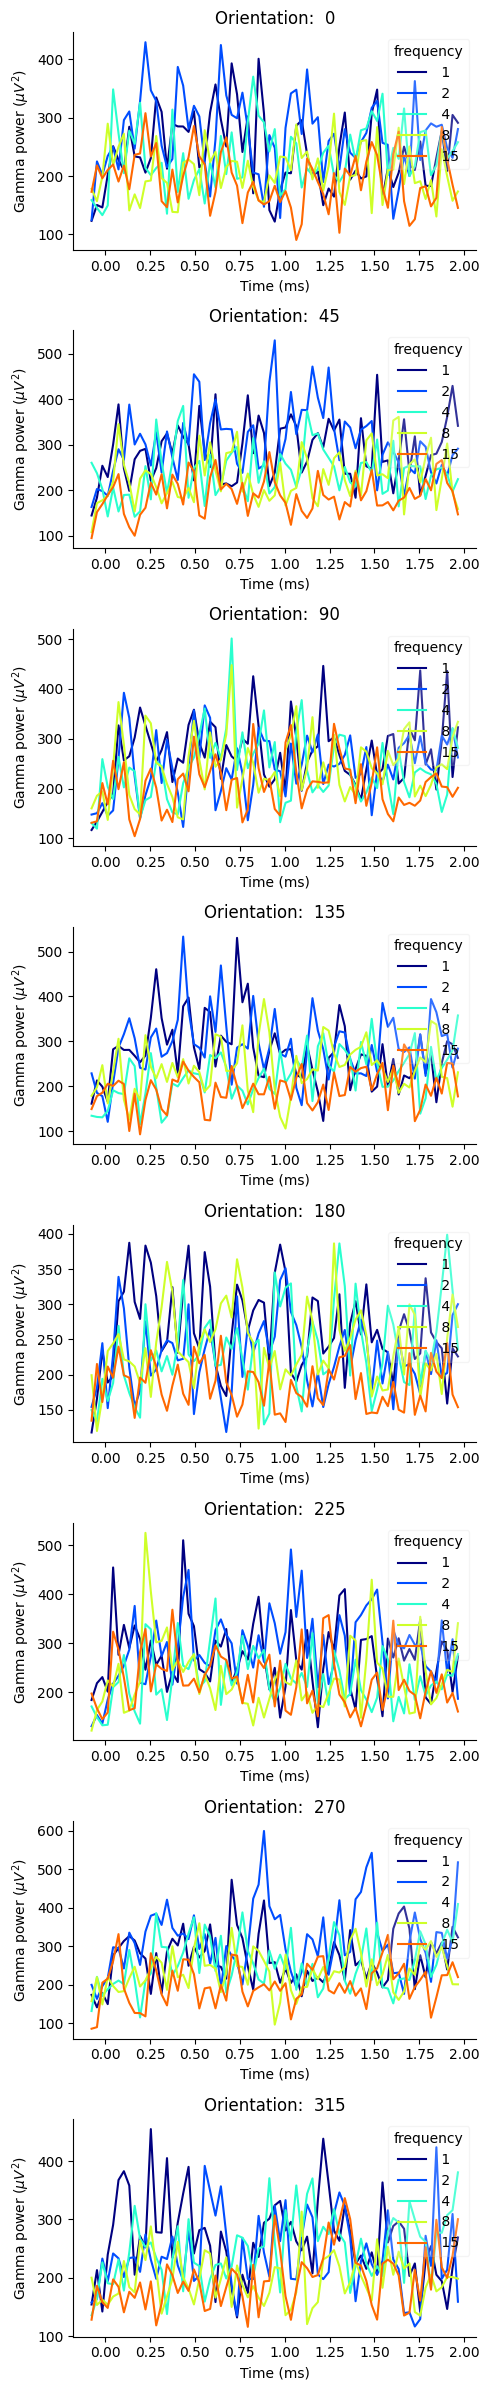

In [40]:
redo = True
while redo:
    whole_duration = (-0.1, grating_duration)
    whole_duration, = get_parameters({'stimulus_whole_duration': whole_duration}, parameters_dict, enter_parameters)

    pop_vec_cond_pc = pop_vec_cond.pop_vec.sel(time_relative_to_stimulus_onset=slice(*whole_duration))
    t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values

    # calculate beta power from amplitude (convert to uV)
    lfp_power = (lfp.amplitude * 1e6) ** 2 / 2
    # average over time bins
    lfp_power = lfp_power.groupby_bins('time_from_presentation_onset', t).mean(dim='time_from_presentation_onset')
    # average over trials
    lfp_power = [lfp_power.sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
    # collect different conditions
    lfp_power = xr.concat(lfp_power, dim=pd.Index(cond_presentation_id, name='condition_id'))
    lfp_power = lfp_power.sel(condition_id=condition_id)
    # average over channels weigthed by number of units near each channel or use the channel with most units
    # beta_power = beta_power.sel(channel=unit_channel.values).mean(dim='channel')
    lfp_power = lfp_power.sel(channel=unit_channel.mode().values[0])

    _, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
    axs = axs.ravel()
    t_mid = (t[:-1] + t[1:]) / 2
    for i, orient in enumerate(pop_vec_cond.orientation.values):
        ax = axs[i]
        for j, tfreq in enumerate(pop_vec_cond.temporal_frequency):
            ax.plot(t_mid, lfp_power.sel(orientation=orient, temporal_frequency=tfreq),
                    color=cmap2[j], label=f'{tfreq: .0f}')
        ax.set_xlabel('Time (ms)')
        if wave == 'gamma':
            ax.set_ylabel(r'Gamma power ($\mu V^2$)')
        else:
            ax.set_ylabel(r'Beta power ($\mu V^2$)')
        ax.legend(loc='upper right', title='frequency', framealpha=0.2)
        ax.set_title(f'Orientation: {orient: .0f}')
    plt.tight_layout()
    fig_disp(f'power_evolve_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

Time interval: (-90.0, 1980.0) ms


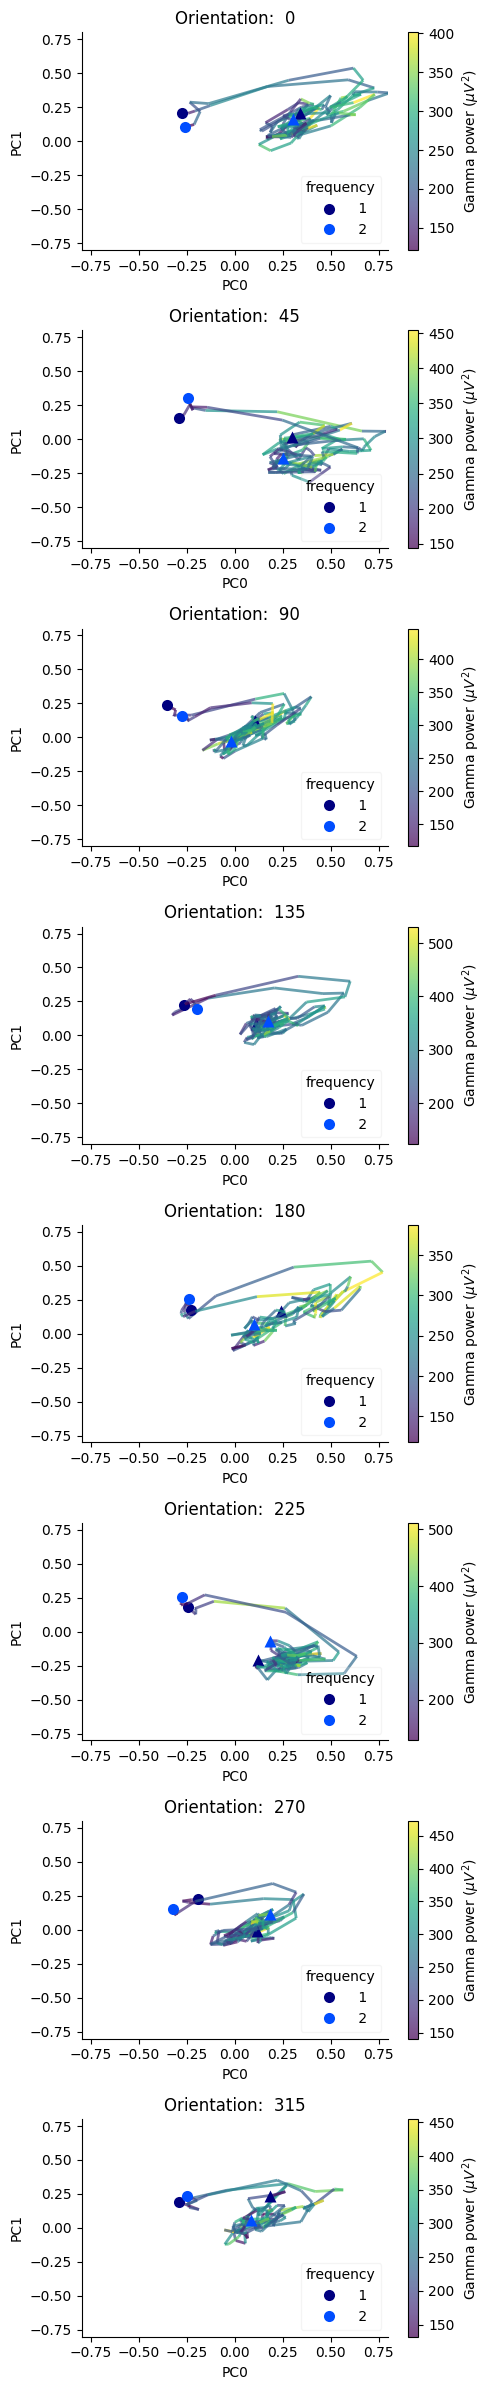

In [41]:
redo = True
while redo:
    temp_freq_idx = list(range(condition_id.temporal_frequency.size))
    PC_disp = [0, 1]
    temp_freq_idx, PC_disp = get_parameters({
        'display_temporal_frequency_index': temp_freq_idx,
        'display_PCs': PC_disp
    }, parameters_dict, enter_parameters)
    sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]

    temp_freq_idx = [0,1,2,3,4]

    _, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
    axs = axs.ravel()
    for i, orient in enumerate(pop_vec_cond.orientation):
        ax = axs[i]
        for j, (tfreq_idx, tfreq) in enumerate(zip(temp_freq_idx, sel_tfreq.values)):
            if j == 2:
                break
            clr = cmap2[tfreq_idx]
            lighten_cmap = get_lighten_cmap(clr, light_scale=0.2, dark_scale=0.8, revert=True)
            pop_vec_tfreq = pop_vec_cond_pc.sel(PC=PC_disp, orientation=orient, temporal_frequency=tfreq)
            beta_power_cond = lfp_power.sel(orientation=orient, temporal_frequency=tfreq)
            line = plot_multicolor_line(*pop_vec_tfreq, c=beta_power_cond, ax=ax, cmap='viridis', linewidth=2, alpha=0.7)
            ax.plot(*pop_vec_tfreq[:, 0], linestyle='none', marker='o',
                    markersize=8, markeredgecolor='none', markerfacecolor=clr, label=f'{tfreq: .0f}')
            ax.plot(*pop_vec_tfreq[:, -1], linestyle='none', marker='^',
                    markersize=8, markeredgecolor='none', markerfacecolor=clr)
            if not j:
                if wave == 'gamma':
                    plt.colorbar(mappable=line, ax=ax, label=r'Gamma power ($\mu V^2$)')
                else:
                    plt.colorbar(mappable=line, ax=ax, label=r'Beta power ($\mu V^2$)')
        ax.set_xlabel(f'PC{PC_disp[0]:d}')
        ax.set_ylabel(f'PC{PC_disp[1]:d}')
        ax.legend(loc='lower right', title='frequency', framealpha=0.2)
        ax.set_title(f'Orientation: {orient: .0f}')
        ax.set_ylim(-0.8,0.8)
        ax.set_xlim(-0.8,0.8)
    plt.tight_layout()

    print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))
    plt.savefig("figures_for_drew/PC_grating_gamma.pdf",dpi=300) 
    fig_disp(f'power_PC_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

Time interval: (-90.0, 1980.0) ms


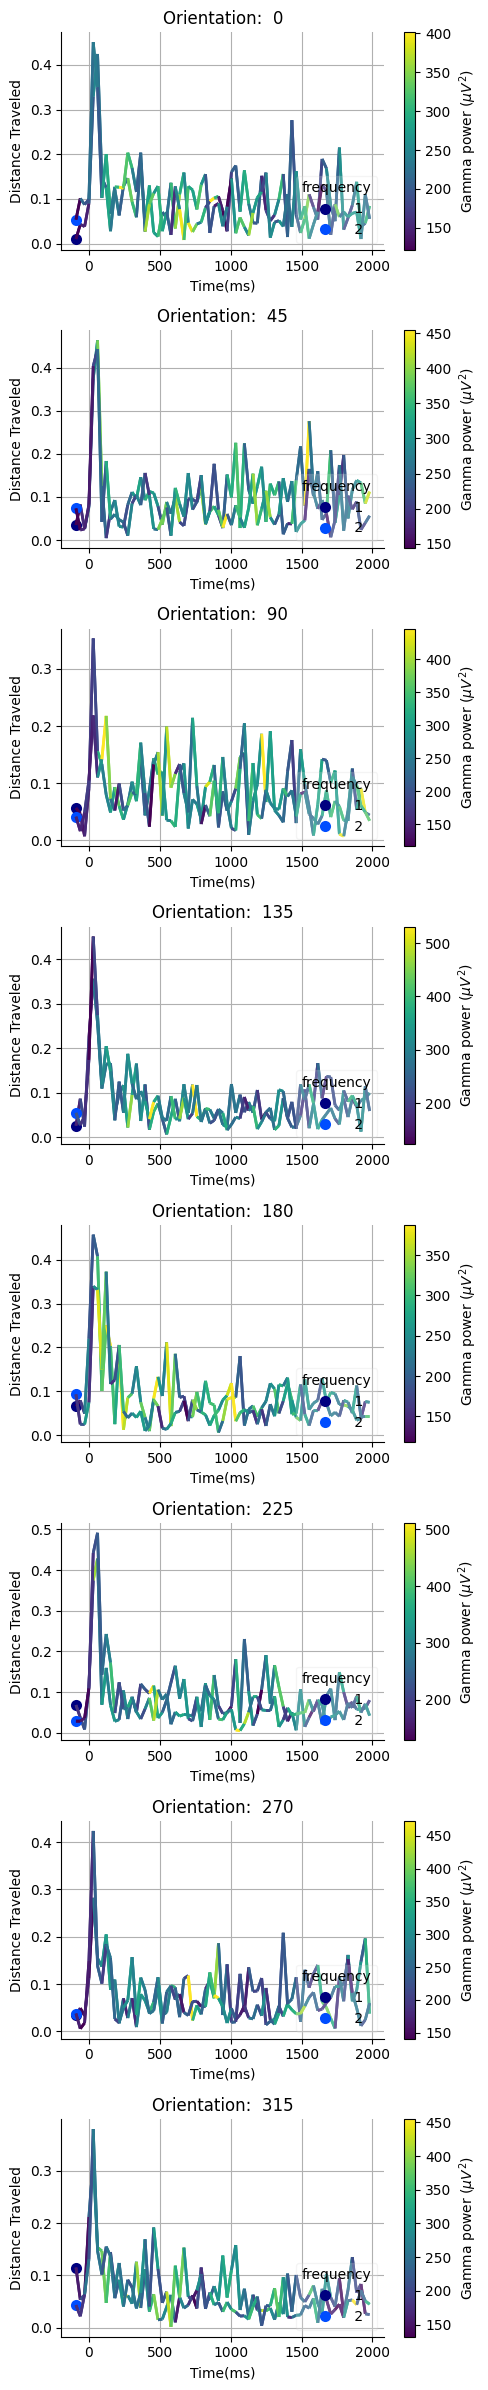

In [42]:
from scipy.ndimage import gaussian_filter1d
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.collections import LineCollection
redo = True
while redo:
    temp_freq_idx = list(range(condition_id.temporal_frequency.size))
    PC_disp = [0, 1]
    temp_freq_idx, PC_disp = get_parameters({
        'display_temporal_frequency_index': temp_freq_idx,
        'display_PCs': PC_disp
    }, parameters_dict, enter_parameters)
    sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]

    beta_power_cond = lfp_power.sel(orientation=orient, temporal_frequency=tfreq)

    _, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
    axs = axs.ravel()
    for i, orient in enumerate(pop_vec_cond.orientation):
        ax = axs[i]
        for j, (tfreq_idx, tfreq) in enumerate(zip(temp_freq_idx, sel_tfreq.values)):
            if j == 2:
                break
            pop_vec_tfreq = pop_vec_cond_pc.sel(PC=PC_disp, orientation=orient, temporal_frequency=tfreq)
            points = np.column_stack(pop_vec_tfreq)[:, None, :]
            points = points[:,-1]
            distances = np.sqrt(np.diff(points[:, 0])**2 + np.diff(points[:, 1])**2)

            sigma = 3  # Adjust sigma for smoothing level
            smoothed_distances = gaussian_filter1d(distances, sigma=sigma)
            smoothed_distances = distances
            time = np.linspace(1000*t[0], 1000*t[-1], 69)
            clr = cmap2[tfreq_idx]
            ax.plot(time[:1],smoothed_distances[:1],linestyle='none', marker='o',
                    markersize=8, markeredgecolor='none', markerfacecolor=clr, label=f'{tfreq: .0f}')

            beta_power_cond = lfp_power.sel(orientation=orient, temporal_frequency=tfreq)
            norm = plt.Normalize(beta_power_cond.min(), beta_power_cond.max())

            segments = np.array([[time[i], smoothed_distances[i], time[i+1], smoothed_distances[i+1]] for i in range(len(time)-1)])
            lc = LineCollection(segments.reshape(-1, 2, 2), cmap='viridis', norm=norm)
                # Set the values used for colormapping
            linewidth=2; linestyle='-'; alpha=1
            lc.set_array(beta_power_cond)
            lc.set_linewidth(linewidth)
            lc.set_linestyle(linestyle)
            lc.set_alpha(alpha)
            if ax is None:
                _, ax = plt.subplots()
            line = ax.add_collection(lc)
            line = ax.add_collection(lc)

            if not j:
                if wave == 'gamma':
                    plt.colorbar(mappable=line, ax=ax, label=r'Gamma power ($\mu V^2$)')
                else:
                    plt.colorbar(mappable=line, ax=ax, label=r'Beta power ($\mu V^2$)')
        ax.set_xlabel('Time(ms)')
        ax.autoscale()
        ax.set_ylabel('Distance Traveled')
        ax.legend(loc='lower right', title='frequency', framealpha=0.2)
        ax.set_title(f'Orientation: {orient: .0f}')
        ax.grid()
    plt.tight_layout()

    print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))
    fig_disp(f'power_PC_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

In [43]:
points = np.column_stack(pop_vec_tfreq)[:, None, :]
points = points[:,-1]
distances_1 = np.sqrt(np.diff(points[:, 0])**2 + np.diff(points[:, 1])**2)

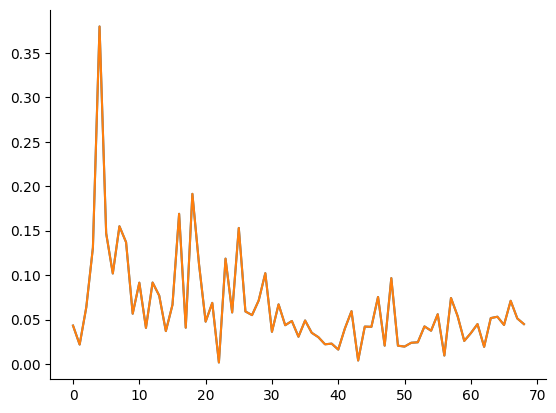

In [44]:
import math
new_dist = []
for i in range(len(points)-1):
    dist = math.hypot(points[i+1][0] - points[i][0], points[i+1][1] - points[i][1])
    new_dist.append(dist)
plt.plot(distances)
plt.plot(new_dist)

## Movie time

In [45]:
stimulus_name = 'natural_movie_one'
filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

with xr.open_dataset(filepath_prefix + '_pop_vec.nc') as f:
    pop_vec_cond = f.load()
pca_df = pd.read_csv(filepath_prefix + '_units_pca.csv', index_col='unit_id')

## get movie lfp

In [46]:
_, presentations_ids, presentations_times, trial_duration = align_movie(session.stimulus_presentations, stimulus_name='natural_movie_one')
extend_time = 0.2
aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0. - extend_time, trial_duration + extend_time))
aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)

# Get filtered LFP
freq_band = [20., 40.]
freq_band, = get_parameters({'filter_freq_band': freq_band}, parameters_dict, enter_parameters)
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

lfp_beta = bandpass_lfp(aligned_lfp, freq_band)

# Get filtered LFP
freq_band = [40., 80.]
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

lfp_gamma = bandpass_lfp(aligned_lfp, freq_band)

Filter band: (20.0, 40.0) Hz
Filter band: (40.0, 80.0) Hz


In [47]:
wave = 'gamma'
if wave == 'gamma':
    lfp = lfp_gamma
    spikes = spike_phase_gamma
else:
    lfp = lfp_beta
    spikes = spike_phase_beta

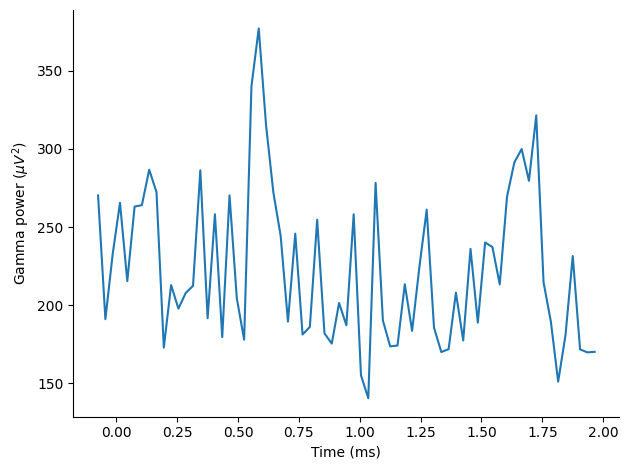

In [48]:
redo = True
while redo:
    whole_duration = (-0.1, trial_duration)
    whole_duration, = get_parameters({'stimulus_whole_duration': whole_duration}, parameters_dict, enter_parameters)

    pop_vec_cond_pc = pop_vec_cond.pop_vec.sel(time_relative_to_stimulus_onset=slice(*whole_duration))
    t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values

    # calculate beta power from amplitude (convert to uV)
    lfp_power = (lfp.amplitude * 1e6) ** 2 / 2
    # average over time bins
    lfp_power = lfp_power.groupby_bins('time_from_presentation_onset', t).mean(dim='time_from_presentation_onset')
    # average over trials
    #lfp_power = [lfp_power.sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
    # collect different conditions
    #lfp_power = xr.concat(lfp_power, dim=pd.Index(cond_presentation_id, name='condition_id'))
    #lfp_power = lfp_power.sel(condition_id=condition_id)
    # average over channels weigthed by number of units near each channel or use the channel with most units
    # beta_power = beta_power.sel(channel=unit_channel.values).mean(dim='channel')
    lfp_power = lfp_power.sel(channel=unit_channel.mode().values[0])
    lfp_power = lfp_power.mean(dim='presentation_id')


    t_mid = (t[:-1] + t[1:]) / 2
    plt.plot(t_mid, lfp_power)
    plt.xlabel('Time (ms)')
    if wave == 'gamma':
        plt.ylabel(r'Gamma power ($\mu V^2$)')
    else:
        plt.ylabel(r'Beta power ($\mu V^2$)')
    plt.tight_layout()
    fig_disp(f'power_evolve_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

Time interval: (-90.0, 1980.0) ms


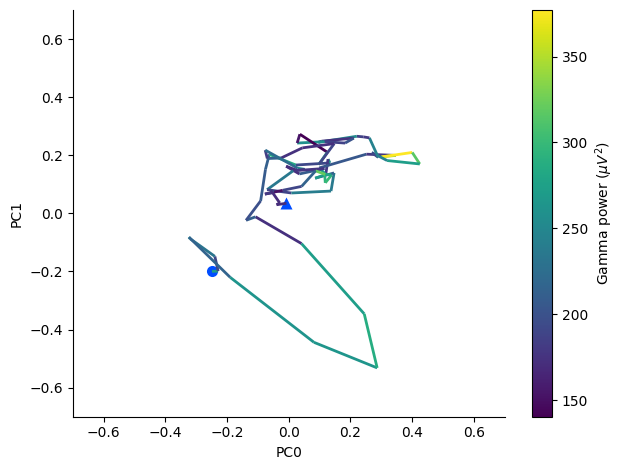

In [49]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

fig, ax = plt.subplots()
PC_disp = [0, 1]
pop_vec = pop_vec_cond_pc.sel(PC=PC_disp)

# Plot starting point as a circle
ax.plot(pop_vec.values[0][0], pop_vec.values[0][1], linestyle='none', marker='o',
        markersize=8, markeredgecolor='none', markerfacecolor=clr, label=f'{tfreq:.0f}')

# Plot ending point as a triangle
ax.plot(pop_vec.values[-1][0], pop_vec.values[-1][1], linestyle='none', marker='^',
        markersize=8, markeredgecolor='none', markerfacecolor=clr)

# Create segments for LineCollection
segments = np.array([[pop_vec.values[i][0], pop_vec.values[i][1], pop_vec.values[i+1][0], pop_vec.values[i+1][1]] 
                     for i in range(len(pop_vec)-1)])

# Reshape for LineCollection
segments = segments.reshape(-1, 2, 2)

# Normalize colormap based on lfp_power
norm = plt.Normalize(lfp_power.min(), lfp_power.max())

# Create a LineCollection object with the defined segments and colormap
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Set colormap data and style for LineCollection
lc.set_array(lfp_power)
lc.set_linewidth(2)
lc.set_linestyle('-')
lc.set_alpha(1)

# Add LineCollection to the plot
ax.add_collection(lc)

# Set labels and plot limits
ax.set_xlabel(f'PC{PC_disp[0]:d}')
ax.set_ylabel(f'PC{PC_disp[1]:d}')
ax.set_ylim(-0.7, 0.7)
ax.set_xlim(-0.7, 0.7)

if wave == 'gamma':
        plt.colorbar(mappable=lc, ax=ax, label=r'Gamma power ($\mu V^2$)')
else:
        plt.colorbar(mappable=lc, ax=ax, label=r'Beta power ($\mu V^2$)')


# Adjust layout
plt.tight_layout()

# Print time interval
print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))

# Display figure (replace with your display function)
fig_disp(f'power_PC_band_{freq_band[0]:g}-{freq_band[1]:g}')

# Optional redo prompt
redo = whether_redo()


## Distance points 

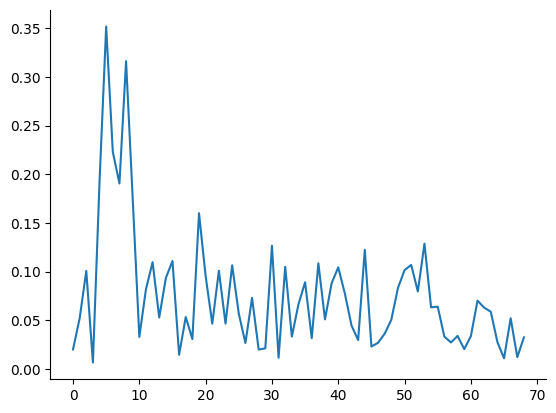

In [50]:
distances = np.sqrt(np.diff(pop_vec.values[:, 0])**2 + np.diff(pop_vec.values[:, 1])**2)
plt.plot(distances)